<a href="https://colab.research.google.com/github/daidh152001/AI-Virtual-Assistant/blob/main/DesignModel_Simple_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Tải dữ liệu

In [ ]:
!wget https://storage.googleapis.com/protonx-cloud-storage/datasets/wakewords/wav_data_1_s.zip
!unzip wav_data_1_s.zip

--2022-05-15 03:11:55--  https://storage.googleapis.com/protonx-cloud-storage/datasets/wakewords/wav_data_1_s.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.98.128, 142.251.107.128, 108.177.11.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918593 (6.6M) [application/zip]
Saving to: ‘wav_data_1_s.zip’

wav_data_1_s.zip    100%[===================>]   6.60M  --.-KB/s    in 0.06s   

2022-05-15 03:11:55 (114 MB/s) - ‘wav_data_1_s.zip’ saved [6918593/6918593]

Archive:  wav_data_1_s.zip
   creating: wav_data_1_s/0-other/
  inflating: wav_data_1_s/0-other/018ab3c2-5af5-447d-811f-a036649f8104.wav  
  inflating: wav_data_1_s/0-other/030edee4-205c-417e-830a-e437aa37ecd0.wav  
  inflating: wav_data_1_s/0-other/0c29feb5-f893-4e4e-90de-c9f9313cff26.wav  
  inflating: wav_data_1_s/0-other/0cf1884a-2eb9-422f-8820-f68526435370.wav  
  inflating: wav_data_1_s/0-o

### 2. Cài đặt thư viện

In [ ]:
import tensorflow as tf
import numpy as np
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
import pathlib
data_dir = pathlib.Path('/content/wav_data_1_s/')

In [ ]:
# !rm -rf '/content/wav_data_1_s/.ipynb_checkpoints'

Truy xuất các thư mục

In [ ]:
commands = np.array(tf.io.gfile.listdir(data_dir))

In [ ]:
commands

array(['2-right', '3-change', '0-other', '1-left'], dtype='<U8')

In [ ]:
for i, item in enumerate(commands):
  print('{} : {}'.format(item.split('-')[1], i))

right : 0
change : 1
other : 2
left : 3


Thống kê số file

In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 335
Number of examples per label: 89
Example file tensor: tf.Tensor(b'/content/wav_data_1_s/2-right/451c6fd6-1fd1-493a-9254-ec9394a482c7.wav', shape=(), dtype=string)


In [ ]:
ratio = 0.9
train_num = int(ratio * num_samples)
train_files = filenames[:train_num]
val_files = filenames[train_num:]
# test_files = filenames[410:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
# print('Test set size', len(test_files))

Training set size 301
Validation set size 34


### 3. Tiền xử lý dữ liệu

In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

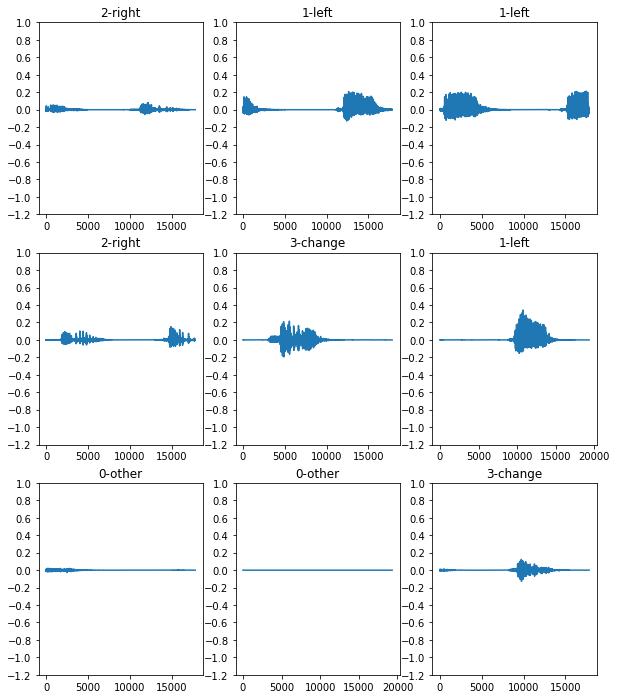

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [ ]:
length = 50000

In [ ]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([length] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [ ]:
for waveform, label in waveform_ds.take(1):
  print(tf.shape(waveform))

tf.Tensor([17833], shape=(1,), dtype=int32)


In [ ]:
waveform

<tf.Tensor: shape=(17833,), dtype=float32, numpy=
array([-3.5400391e-03, -2.7465820e-03, -2.0141602e-03, ...,
       -1.2207031e-04, -6.1035156e-05,  3.0517578e-05], dtype=float32)>

In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)
  print(spectrogram)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

tf.Tensor(
[[8.3771599e-03 8.5036820e-03 7.8900538e-02 ... 1.3889524e-04
  3.0201033e-04 5.2344147e-04]
 [7.1309088e-03 7.7962312e-03 7.7840425e-02 ... 9.1152953e-04
  5.2484049e-04 3.4941803e-04]
 [3.3117721e-03 1.4436456e-02 6.9486670e-02 ... 6.5715937e-04
  3.6379744e-04 6.1054598e-05]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]], shape=(389, 129), dtype=float32)
Label: 2-right
Waveform shape: (17833,)
Spectrogram shape: (389, 129)
Audio playback


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


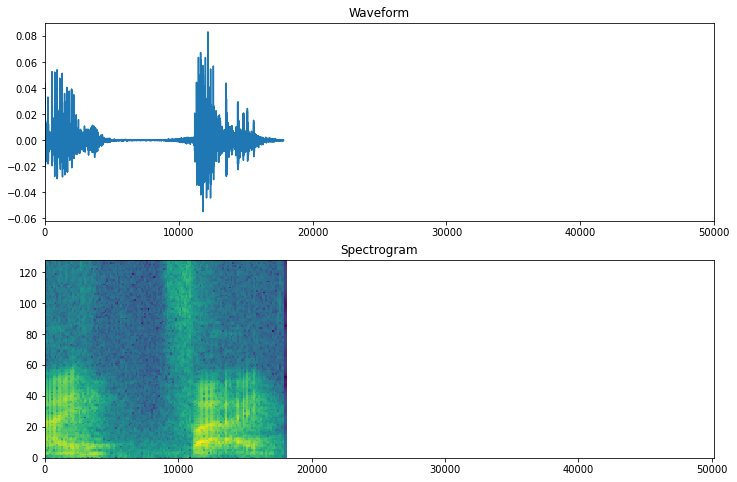

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, length])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

In [ ]:
list(spectrogram_ds.take(1))[0][0].shape

TensorShape([389, 129, 1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


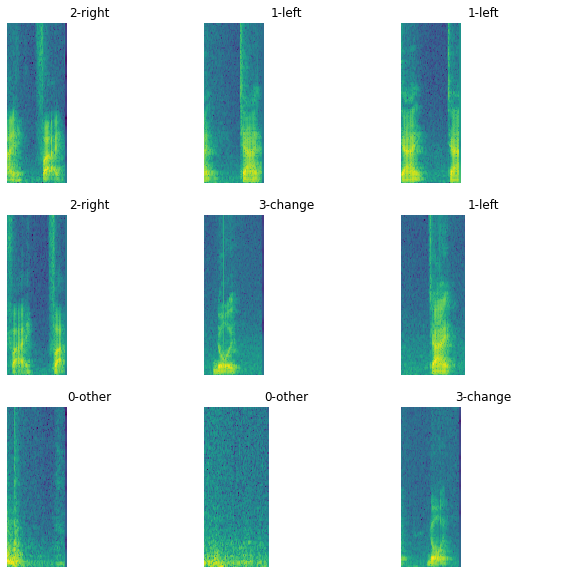

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
# test_ds = preprocess_dataset(test_files)

In [ ]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### 4. Cấu trúc model

In [ ]:
# voice = tf.keras.models.load_model('voice.h5')

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(80, 80), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer='l2'),
    layers.Dense(128, activation='relu', kernel_regularizer='l2'),
    layers.Dropout(0.1),
    layers.Dense(num_labels),
])

# model.summary()



Input shape: (389, 129, 1)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 80, 80, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 80, 80, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 78, 78, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 76, 76, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 38, 38, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 38, 38, 64)        0

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 11
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=150,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=10),
)

Epoch 1/150
10/10 [==============================] - 15s 190ms/step - loss: 8.1065 - accuracy: 0.3389 - val_loss: 7.9651 - val_accuracy: 0.7059
Epoch 2/150
10/10 [==============================] - 0s 29ms/step - loss: 7.8299 - accuracy: 0.6545 - val_loss: 7.7532 - val_accuracy: 0.8529
Epoch 3/150
10/10 [==============================] - 0s 30ms/step - loss: 7.6008 - accuracy: 0.7708 - val_loss: 7.5470 - val_accuracy: 0.8235
Epoch 4/150
10/10 [==============================] - 0s 29ms/step - loss: 7.3615 - accuracy: 0.8605 - val_loss: 7.3398 - val_accuracy: 0.8824
Epoch 5/150
10/10 [==============================] - 0s 31ms/step - loss: 7.1367 - accuracy: 0.8870 - val_loss: 7.1386 - val_accuracy: 0.8824
Epoch 6/150
10/10 [==============================] - 0s 29ms/step - loss: 6.9253 - accuracy: 0.9136 - val_loss: 6.9486 - val_accuracy: 0.8824
Epoch 7/150
10/10 [==============================] - 0s 30ms/step - loss: 6.7137 - accuracy: 0.9302 - val_loss: 6.7679 - val_accuracy: 0.8824
Epoc

In [ ]:
model.evaluate(val_ds)

2/2 [==============================] - 0s 9ms/step - loss: 1.9472 - accuracy: 0.9118


[1.9472225904464722, 0.9117646813392639]

In [ ]:
model.save('./voice.h5')
from google.colab import files
files.download('./voice.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cp /content/voice.h5 /content/drive/MyDrive/models